In [1]:
import os
import shutil
import sys
from glob import glob
from pathlib import Path
from typing import *

import lightning as pl
import numpy as np
import pandas as pd
import PIL
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as F
from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
from torch.nn import Linear, Sequential
from torch.nn import functional as TF
from torch.optim import SGD, AdamW, lr_scheduler
from torch.utils.data import DataLoader, Dataset
from torchmetrics.classification import MulticlassAccuracy
from torchvision import datasets
from torchvision.datasets import ImageFolder
from torchvision.io import read_image
from tqdm.auto import tqdm
from transformers import AutoImageProcessor, ResNetModel

np.random.seed(100)

## Download data from ImageNet

We use a simple , open-source dataset for our demonstration.
CIFAR-10 is one of the most popular datsets.
However it requires some effort to ownload it and pre-process it. 
We have out data as follows


Splits: `train` | `validation` | `test`

There are 10 classes:        
    - airplanes     
    - cars        
    - birds        
    - cats         
    - deer         
    - dogs          
    - frogs         
    - horses         
    - ships         
    - trucks        

## Create s subset of the data 

In [2]:
def create_subset(main_dir_path="CIFAR_10", subset_dir="CIFAR_10_subset"):
    split_count = {"train": 500, "validation": 50, "test": 500}

    for data_split, count in tqdm(split_count.items()):
        class_dirs = glob(os.path.join(f"{main_dir_path}/{data_split}/**"))
        for class_dir in tqdm(class_dirs):
            files = glob(os.path.join(class_dir, "**"))
            files = np.random.choice(files, count, replace=False)
            class_name = os.path.basename(class_dir)
            tgt_dir = os.path.join(subset_dir, data_split, class_name)
            if os.path.exists(tgt_dir):
                shutil.rmtree(tgt_dir)

            Path(tgt_dir).mkdir(exist_ok=True, parents=True)

            img_file_name = [os.path.basename(_) for _ in files]
            for img_file in files:
                img_file_name = os.path.basename(img_file)
                tgt = os.path.join(tgt_dir, img_file_name)
                shutil.copy(img_file, tgt)

In [68]:
create_subset()

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [3]:
def verify_image(path):
    """
    Ensure image path points to a valid image file
    """
    try:
        Image.open(path)
    except IOError:
        return False
    return True


def get_data_split(split="train"):
    """
    Read data b split name
    """
    assert split in ["train", "test", "validation"]
    transform = transforms.Compose(
        [
            transforms.Resize(
                [224, 224]
            ),  # Resizing the image as the VGG only take 224 x 244 as input size
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )
    ds = ImageFolder(
        root=f"./CIFAR_10_subset/{split}", is_valid_file=verify_image, transform=transform
    )
    return ds

## Visuazlize some sample images

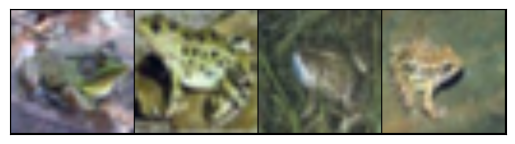

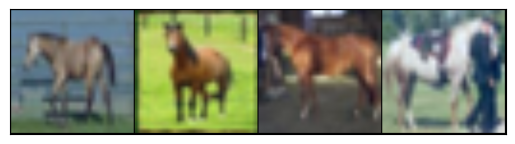

In [5]:
def viz_samples(count=6):
    ds = get_data_split("validation")
    start = np.random.randint(0, len(ds) - count)
    images = [ds[start + idx][0] for idx in range(count)]
    grid = torchvision.utils.make_grid(images, nrow=4, normalize=True)

    def show(imgs):
        if not isinstance(imgs, list):
            imgs = [imgs]
        fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
        for i, img in enumerate(imgs):
            img = img.detach()
            img = F.to_pil_image(img)
            axs[0, i].imshow(np.asarray(img))
            axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    show(grid)

viz_samples(count=4)
viz_samples(count=4)

### Our task being Image classification, we have multiple choices for models. 

### While model can be trained from scratch, we adopt the approach to finetune a model.

### `Transfer Learning` is one the methodologies that makes AutoML work, and we are employing that here.
